In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import random
%matplotlib inline

In [107]:
args = {'lr':0.01,
        'train epochs':500,
        'hidden layers':15,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'correlation':0.0,
        'input features': 20,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler(),
        }

now = datetime.now()

# Data Prep

In [108]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [109]:
df = pd.read_excel('wide_range.xlsx')

In [110]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [111]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [112]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [113]:
# add noise
X_noisy = add_noise(X, args['noise'])

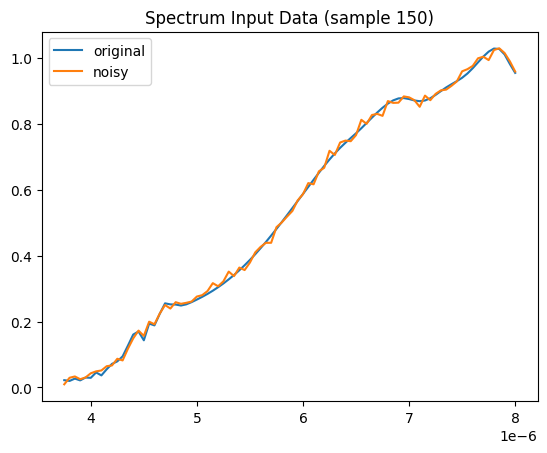

In [114]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [115]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [117]:
for layer in layers:
    inputs = X_train
    targets = y_train[layer['col']]

    rfe = RFE(estimator=LinearRegression(), n_features_to_select=args['input features'])

    rfe.fit(inputs, targets)

    selected_features = X.columns[rfe.support_]

    layer['features'] = selected_features

    print(f'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n')


KeyboardInterrupt: 

In [ ]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [ ]:
criterion = args['train criterion']

In [ ]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    # instantiate model
    model = FeedForward(input.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])
    print(f'hidden layer sizes: {model.hidden_sizes}')

    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(input)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
hidden layer sizes: [20, 18, 17, 16, 15, 13, 12, 11, 10, 8, 7, 6, 5, 3, 2, 1]
epoch: 50, loss = 15.66295051574707
epoch: 100, loss = 11.496597290039062
epoch: 150, loss = 11.362832069396973
epoch: 200, loss = 11.308271408081055
epoch: 250, loss = 11.2874174118042
epoch: 300, loss = 11.268057823181152
epoch: 350, loss = 11.23458194732666
epoch: 400, loss = 11.226174354553223
epoch: 450, loss = 11.2177152633667
epoch: 500, loss = 11.214340209960938
best loss: 11.214340209960938 in epoch 500

layer 2
hidden layer sizes: [20, 18, 17, 16, 15, 13, 12, 11, 10, 8, 7, 6, 5, 3, 2, 1]
epoch: 50, loss = 65.38359832763672
epoch: 100, loss = 10.2247953414917
epoch: 150, loss = 9.871678352355957
epoch: 200, loss = 9.57865047454834
epoch: 250, loss = 9.382112503051758
epoch: 300, loss = 9.230523109436035
epoch: 350, loss = 9.154417037963867
epoch: 400, loss = 9.128070831298828
epoch: 450, loss = 9.107857704162598
epoch: 500, loss = 9.084161758422852
best loss: 9.084161758422852 in epoch 500

l

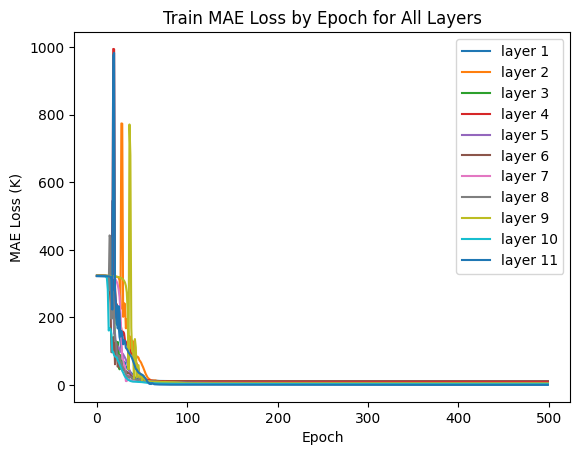

In [ ]:
for layer in layers:
    plt.plot(layer['train losses'], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [ ]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

print(f"Average: {sum(test_losses)/len(test_losses)}")

layer 1 loss: 12.479124069213867
layer 2 loss: 9.317044258117676
layer 3 loss: 10.395929336547852
layer 4 loss: 9.936704635620117
layer 5 loss: 6.0495734214782715
layer 6 loss: 4.991076469421387
layer 7 loss: 5.22391414642334
layer 8 loss: 5.840560436248779
layer 9 loss: 5.341465950012207
layer 10 loss: 2.4492697715759277
layer 11 loss: 0.2510813772678375
Average: 6.570522170175206


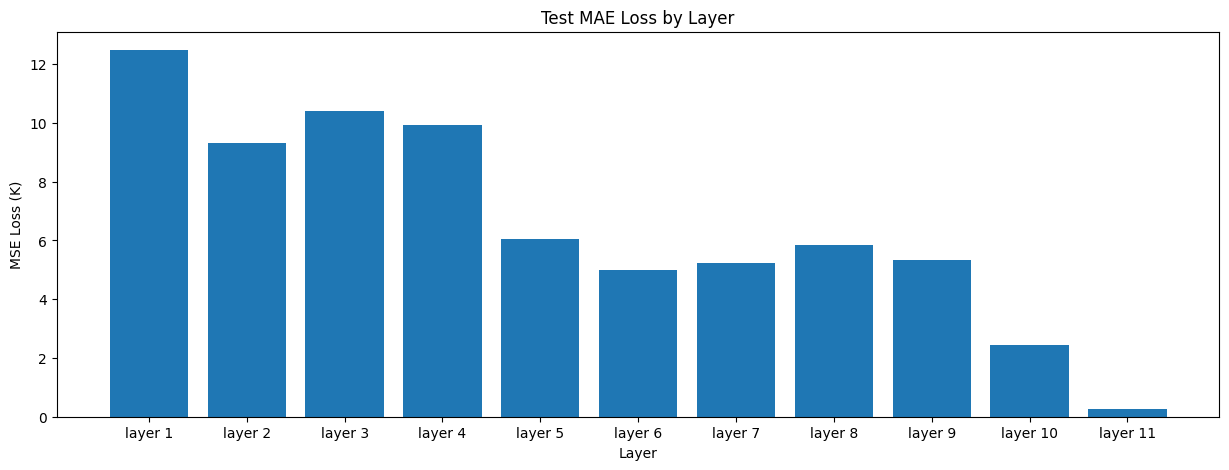

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(y.columns, test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [ ]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [ ]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

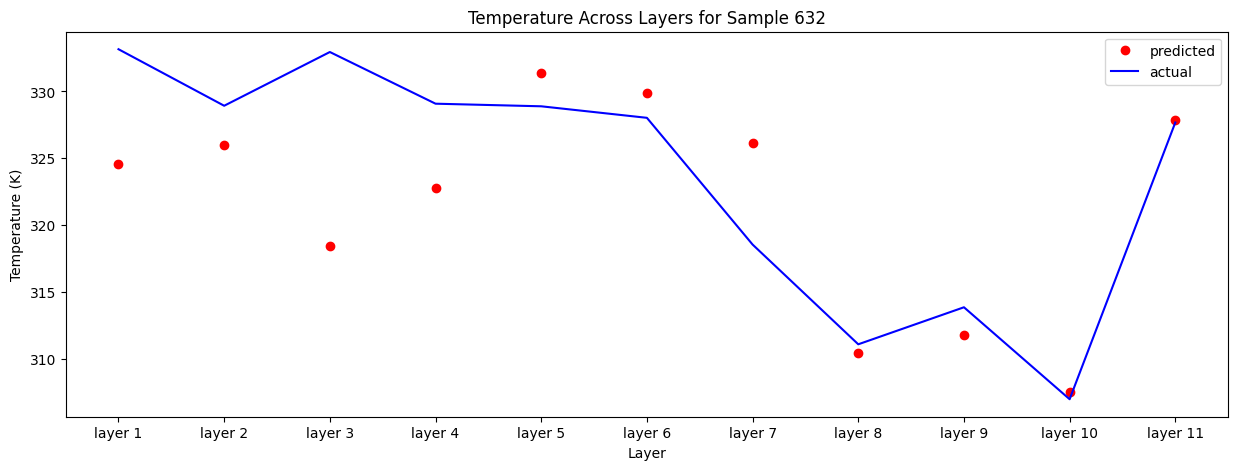

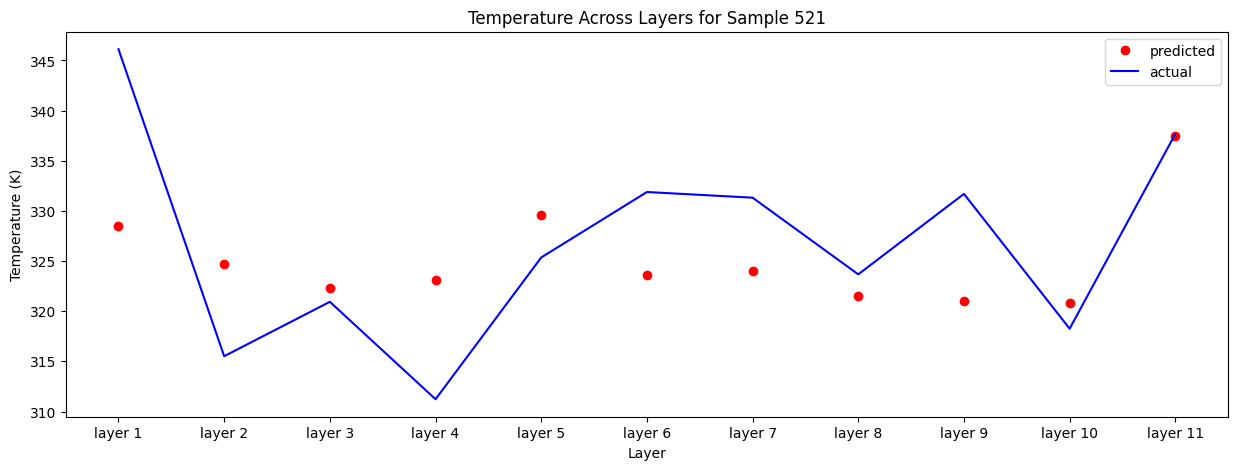

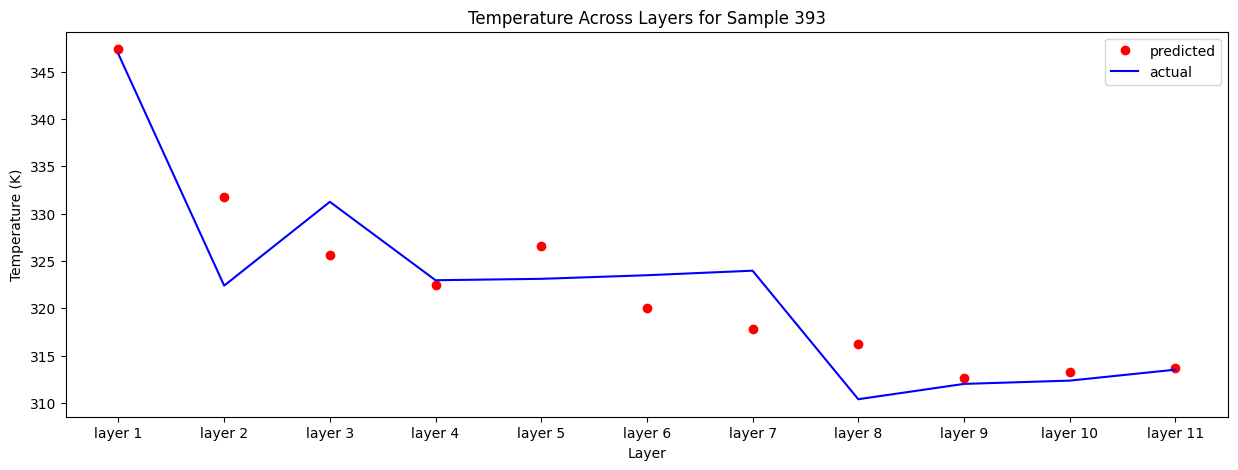

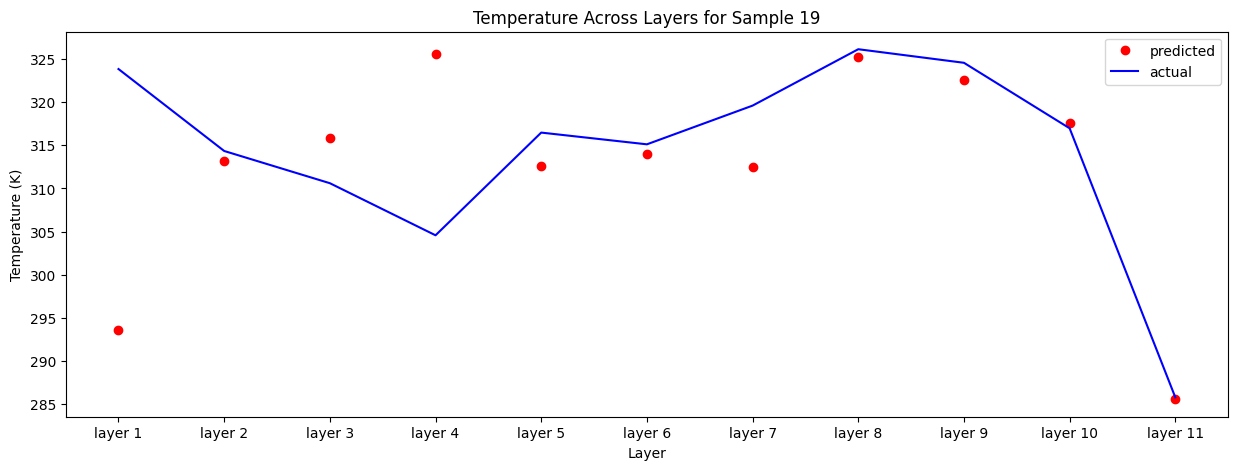

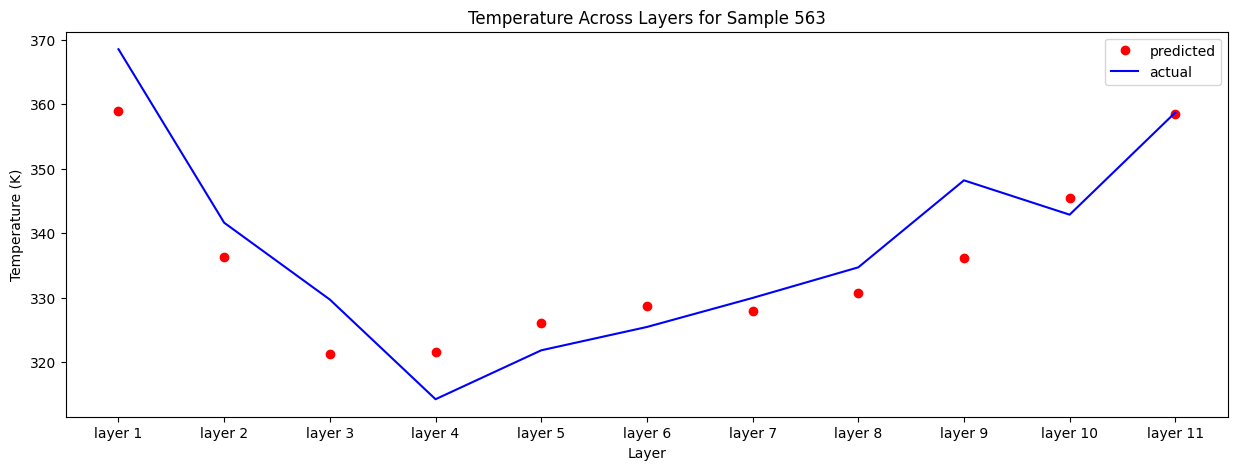

In [ ]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)

In [ ]:
with open('ff_one_layer_test.txt', "a") as f:
    f.write('===================================\n' +'|'.ljust(5) + f'{now.strftime("%m/%d/%Y, %H:%M:%S")}\n|\n')
    
    loss_str = ''
    for i in range(1, 12):
        loss_str += f'| layer {i} loss: '.ljust(20) + f'{test_losses[i-1]:.3f}\n'

    
    arg_str = ''
    for key in args:
        arg_str += f'| {key}:'.ljust(20) + f'{args[key]}\n'

    f.write('|'.ljust(10) + 'Losses\n' + f'|----------------------------------\n{loss_str}|\n'+ '|'.ljust(10) + 'Args' 
            + f'\n|----------------------------------\n{arg_str}====================================\n\n')